In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

#### Training Data

In [98]:
train_df = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])

In [6]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df

,index,0
0,parcelid,0
1,logerror,0
2,transactiondate,0


So we do not have missing values in the training data.

#### Log Error Distribution

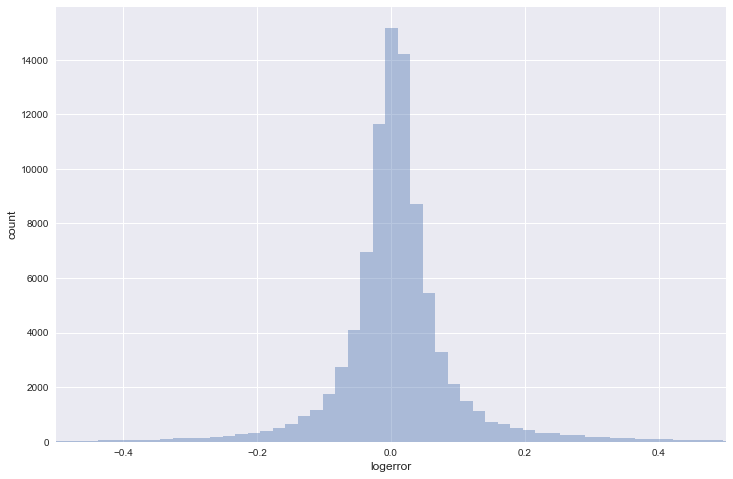

In [3]:
sns.distplot(train_df.logerror.values, bins=500, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.xlim([-0.5, 0.5])
plt.show()

We can see log error is basically following a normal distribution.

#### Absolute Log Error Over Time

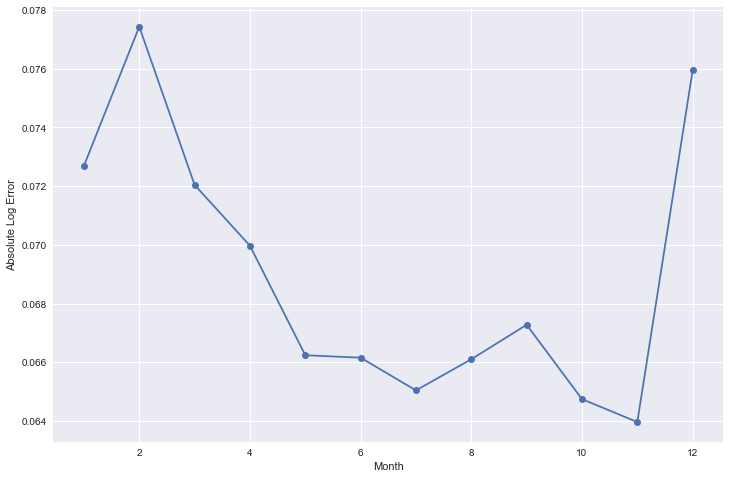

In [84]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month
train_df['abs_logerror'] = train_df['logerror'].abs()
mean_logError_df = train_df.groupby('transaction_month')['abs_logerror'].mean().reset_index()

plt.plot(mean_logError_df['transaction_month'], mean_logError_df['abs_logerror'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Absolute Log Error')

There seems to be a decrease of absolute log error over time. As we only have data in 2016, so we are grouping by month.

#### Property 2016

In [99]:
prop_df = pd.read_csv("properties_2016_test.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Columns Missing Value Counts

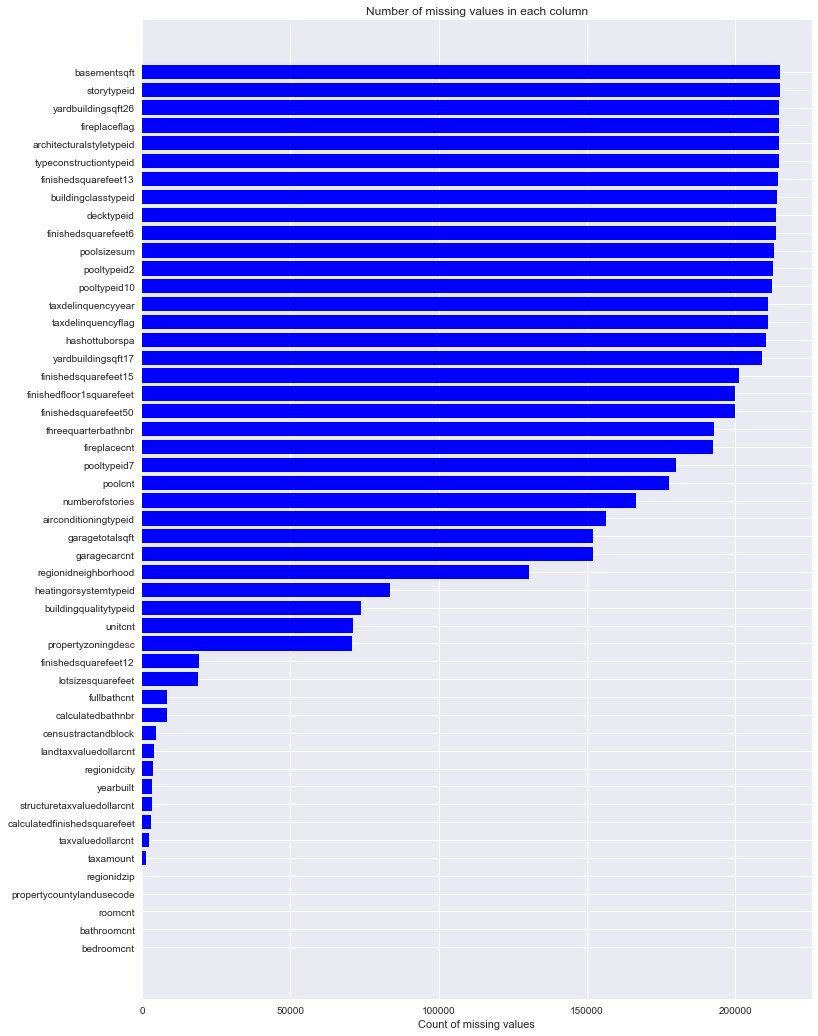

In [30]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

#### Merge two tables

In [100]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')

Now let's replace missing values with mean values

In [103]:
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values, inplace=False)

In [102]:
# train_df_new['storytypeid'].head(30)
# mean_values = train_df.mean(axis=0)
# len(mean_values)
train_df.shape


(90275, 60)

#### Correlation Coefficient

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


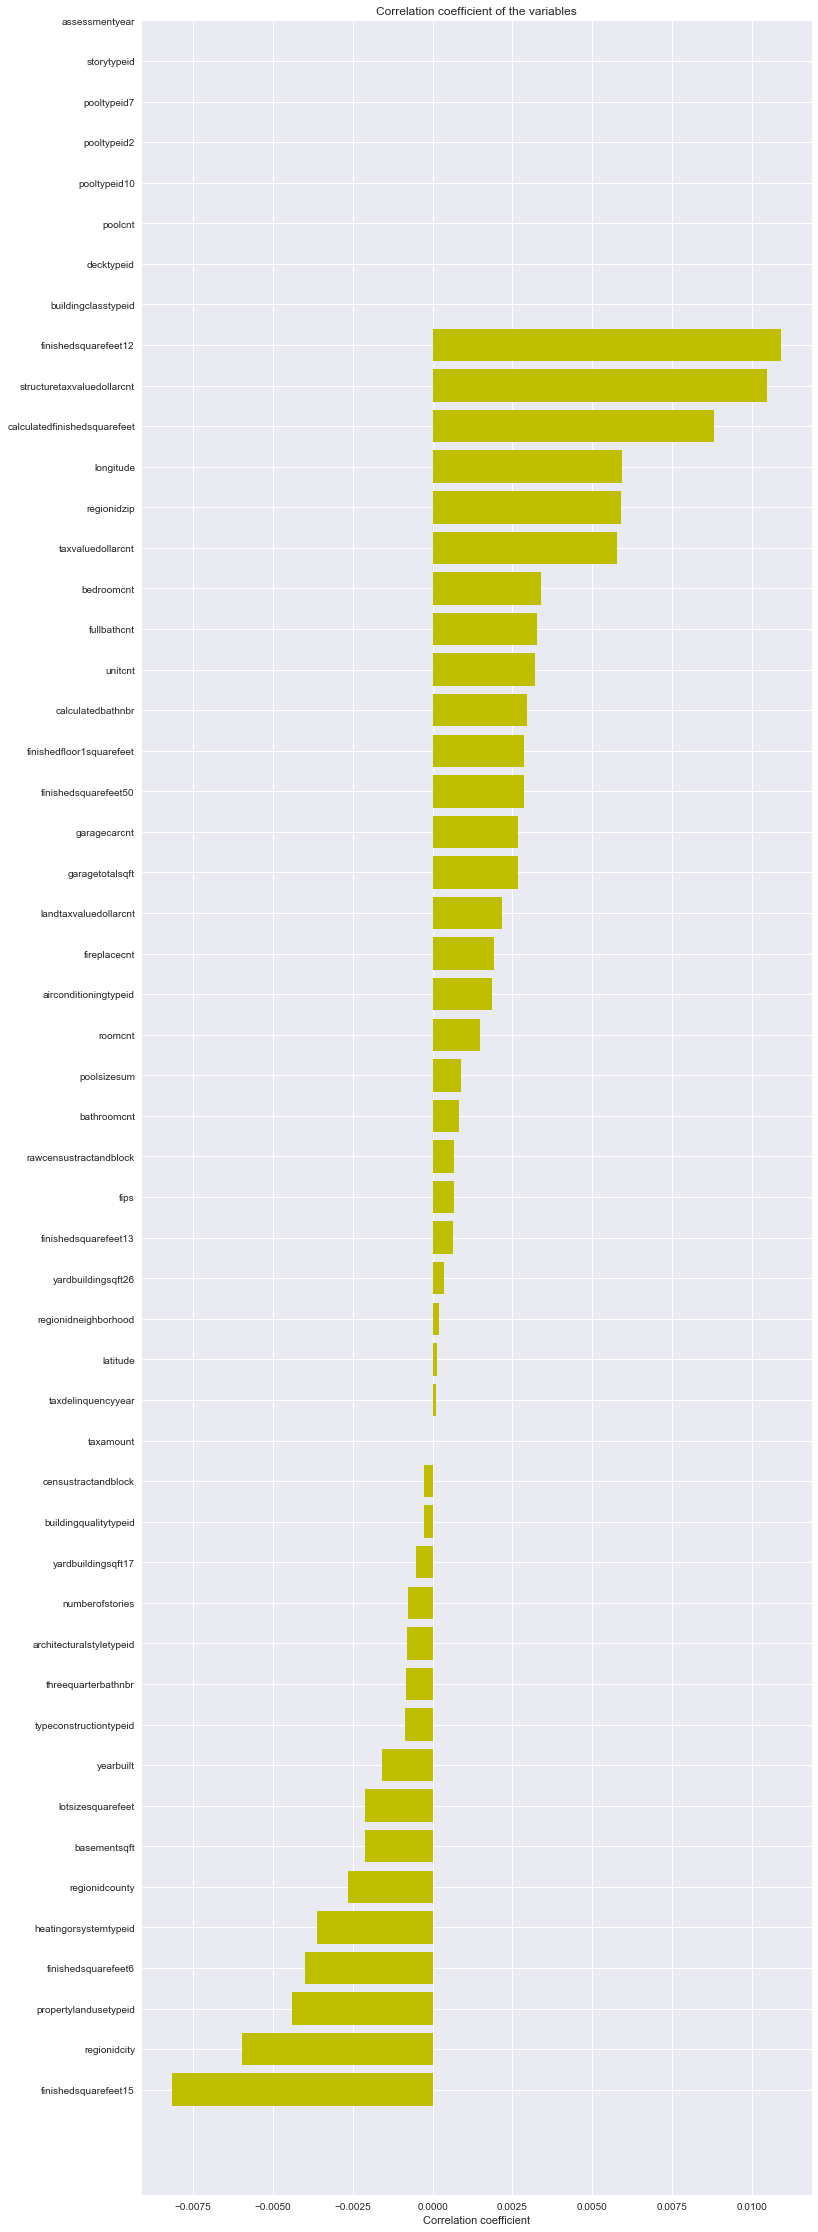

In [72]:
x_cols = [col for col in train_df_new.columns if col not in ['logerror', 'abs_logerror'] if train_df_new[col].dtype=='float64']

labels = []
values = []

for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new['logerror'].values)[0,1])
    
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values}).sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

Let's select columns with high coorelation values.

In [78]:
corr_df_sel = corr_df[(corr_df['corr_values']>0.0075) | (corr_df['corr_values'] < -0.0035)]
corr_df_sel['abs_corr_values'] = corr_df['corr_values'].abs()
corr_df_sel = corr_df_sel.sort_values(by='abs_corr_values', ascending=False)
corr_df_sel

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,col_labels,corr_values,abs_corr_values
11,finishedsquarefeet12,0.010917,0.010917
45,structuretaxvaluedollarcnt,0.010463,0.010463
10,calculatedfinishedsquarefeet,0.008829,0.008829
13,finishedsquarefeet15,-0.008156,0.008156
32,regionidcity,-0.005987,0.005987
30,propertylandusetypeid,-0.004412,0.004412
15,finishedsquarefeet6,-0.003996,0.003996
21,heatingorsystemtypeid,-0.003628,0.003628


#### Correlation Heatmap

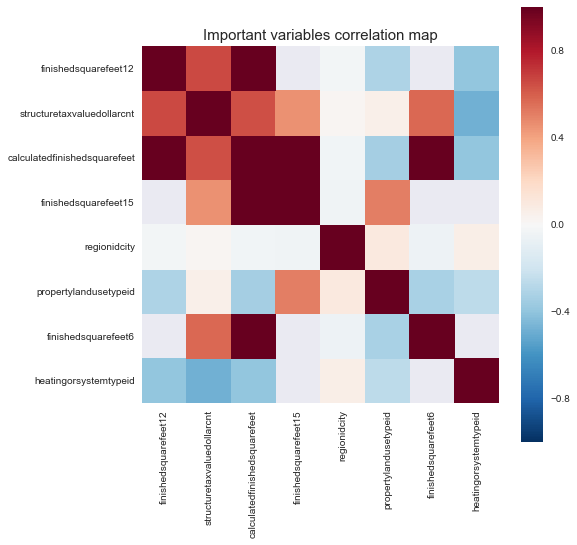

In [79]:
temp_df = train_df[corr_df_sel['col_labels']]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

#### Build Year Density

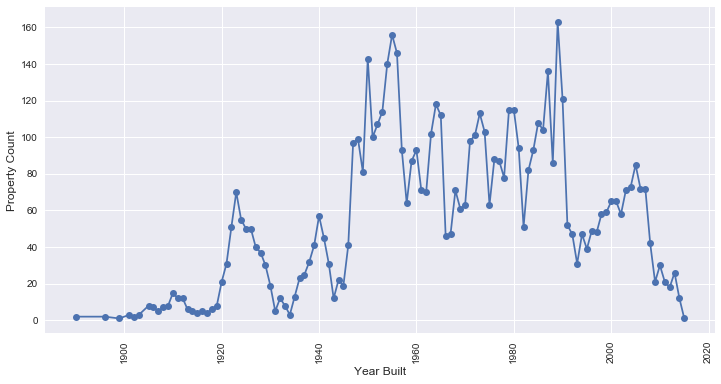

In [80]:
cnt_yearbuilt = train_df['yearbuilt'].value_counts().reset_index()
cnt_yearbuilt.columns = ['year', 'property_cnt']
cnt_yearbuilt['year'] = cnt_yearbuilt['year'].astype(int)
cnt_yearbuilt = cnt_yearbuilt.sort_values(by = 'year')

plt.figure(figsize=(12,6))
plt.plot(cnt_yearbuilt['year'], cnt_yearbuilt['property_cnt'], marker='o', linestyle='-')

# sns.barplot(cnt_yearbuilt['year'], cnt_yearbuilt['property_cnt'])
plt.xlabel('Year Built', fontsize=12)
plt.ylabel('Property Count', fontsize=12)
plt.xticks(rotation=90)
plt.show()

#### Build Year V.S. Absolute LogError

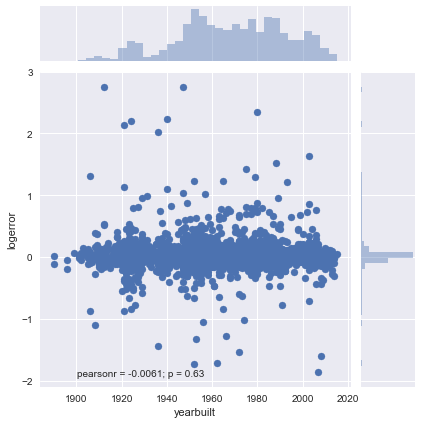

In [81]:
# sns.regplot(x='yearbuilt', y='abs_logerror', data=train_df, scatter_kws={"s": 10, "color":"orange"}, line_kws={"color":"black"})

sns.jointplot(x='yearbuilt', y='logerror', data=train_df)

#### Tax Value Dollar Count V.S. Absolute LogError

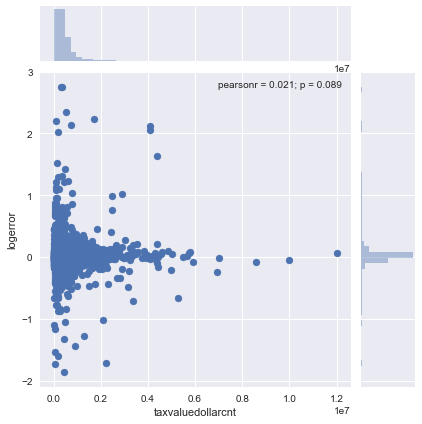

In [82]:
# new_df = train_df.loc[ (train_df['taxvaluedollarcnt'] < 3000000) & (train_df['taxvaluedollarcnt'] > 30000)][['taxvaluedollarcnt', 'abs_logerror']]

# sns.regplot(x='taxvaluedollarcnt', y='abs_logerror', data=train_df, scatter_kws={"s": 10, "color":"orange"}, line_kws={"color":"black"})

sns.jointplot(x='taxvaluedollarcnt', y='logerror', data=train_df)

#### Finished Living Area V.S. Absolute LogError

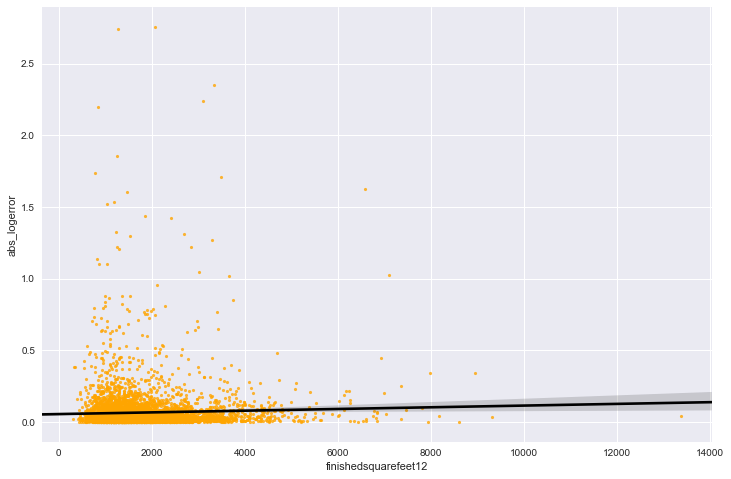

In [85]:
sns.regplot(x='finishedsquarefeet12', y='abs_logerror', data=train_df, scatter_kws={"s": 10, "color":"orange"}, line_kws={"color":"black"})

# sns.jointplot(x='finishedsquarefeet12', y='logerror', data=train_df)

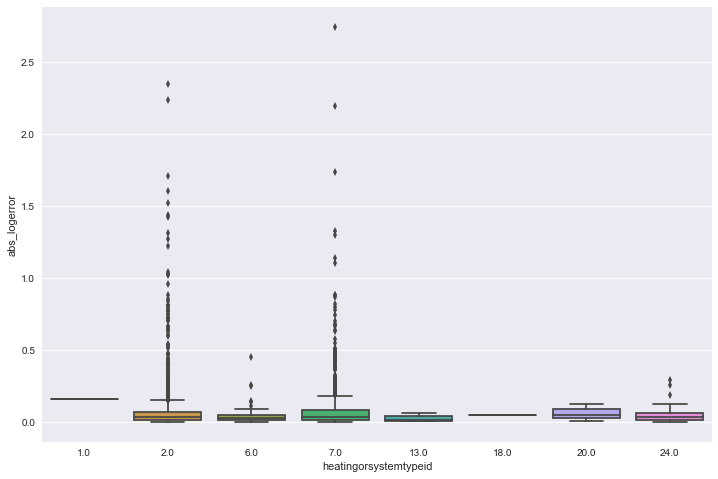

In [87]:
# Architectural Type V.S. Absolute Log Error

sns.boxplot(x='heatingorsystemtypeid', y='abs_logerror', data=train_df)

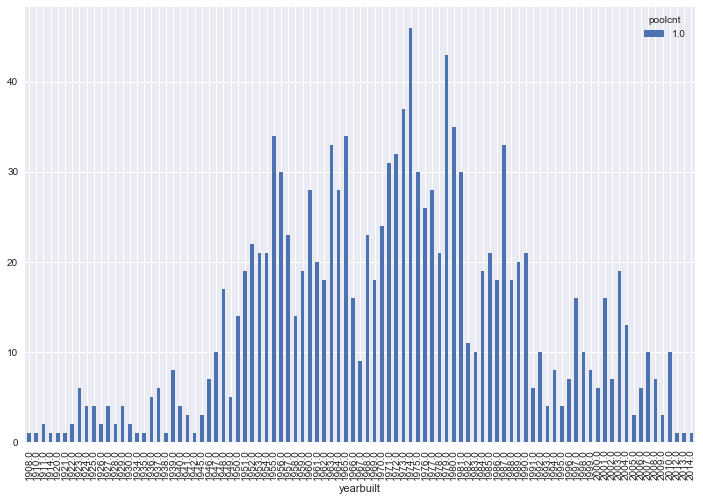

In [144]:
test_df = train_df.groupby(['yearbuilt', 'poolcnt'])
test_df = test_df['parcelid'].count().unstack('poolcnt')
test_df.plot(kind='bar', stacked=True)

In [131]:
from r-ggplot2 import *

ggplot(aes(x='latitude', y='longitude', color='abs_logerror'), data=train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')

SyntaxError: invalid syntax (<ipython-input-131-fea548e4a3ba>, line 1)

Now let's clean the property dataset and replace the missing values.

In [120]:
missing_df = train_df_new.isnull().sum().reset_index()
missing_df.columns = ['col', 'missing_cnt']
missing_df = missing_df[(missing_df['missing_cnt'] > 0) & (missing_df['missing_cnt'] < train_df_new.shape[0])]

In [121]:
missing_df

,col,missing_cnt
34,propertycountylandusecode,83813
36,propertyzoningdesc,86045
57,taxdelinquencyflag,90148


In [125]:
for col in missing_df['col']:
    train_df_new[col].fillna(train_df_new[col].value_counts().reset_index().iloc[0, 1], inplace=True)

In [127]:
train_df_new.to_csv('cleanData.csv')